In [1]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM, Bidirectional
from tensorflow.python.ops.math_ops import reduce_prod
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

/home/varungunda/snap/jupyter/common/lib/python3.7/site-packages/joblib/_multiprocessing_helpers.py:45: UserWarning: [Errno 13] Permission denied.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


In [2]:
#Get the stock quote
df = web.DataReader('AMZN',data_source='yahoo',start='2012-01-01', end='2021-04-26')

#Show the data

df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,179.479996,175.550003,175.889999,179.029999,5110800,179.029999
2012-01-04,180.500000,176.070007,179.210007,177.509995,4205200,177.509995
2012-01-05,178.250000,174.050003,175.940002,177.610001,3809100,177.610001
2012-01-06,184.649994,177.500000,178.070007,182.610001,7008400,182.610001
2012-01-09,184.369995,177.000000,182.759995,178.559998,5056900,178.559998
...,...,...,...,...,...,...
2021-04-20,3382.989990,3316.000000,3373.600098,3334.689941,2623000,3334.689941
2021-04-21,3362.860107,3303.810059,3316.000000,3362.020020,2211200,3362.020020
2021-04-22,3372.870117,3301.449951,3371.679932,3309.040039,2580600,3309.040039


In [3]:
#Get the number of rows and columns in the data set
df.shape

(2343, 6)

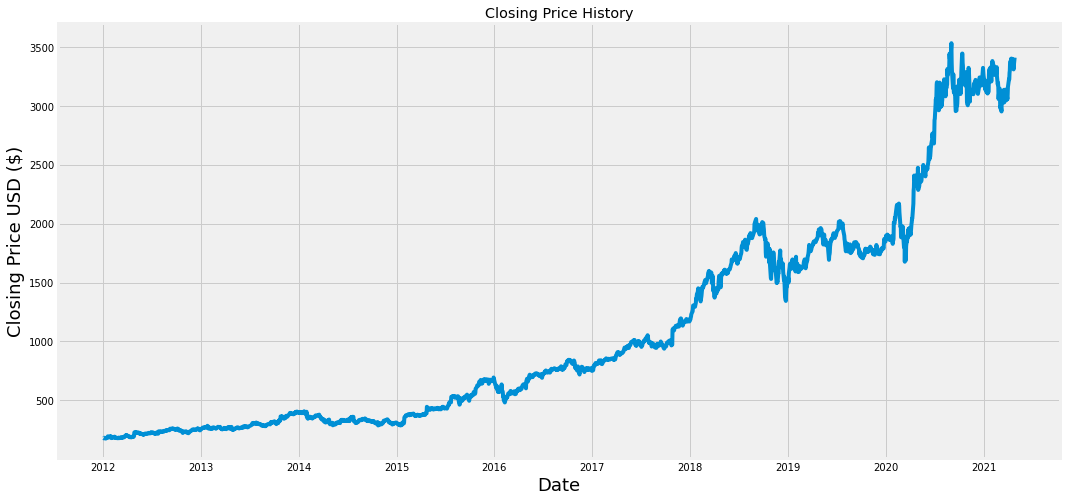

In [4]:
#Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Closing Price History')
plt.plot(df['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Closing Price USD ($)',fontsize=18)
plt.show()

In [5]:
#Create a new data frame with only the close column
data = df.filter(['Close'])
#Convert the dataframe to a numpy array
dataset = data.values
#Get the number of rows to train the model on
training_data_len = math.ceil(len(dataset) * 0.8)
training_data_len

1875

In [6]:
#Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[9.23852679e-04],
       [4.70866468e-04],
       [5.00669928e-04],
       ...,
       [9.33718197e-01],
       [9.43206993e-01],
       [9.63507906e-01]])

In [7]:
#Create the training data set
#Create the scaled training data set
train_data = scaled_data[0:training_data_len,:]
#Split the data into x_train and y_train data sets
x_train = []
y_train = []

past_steps = 35


for i in range(past_steps,len(train_data)):
    x_train.append(train_data[i-past_steps:i,0])
    y_train.append(train_data[i,0])


In [8]:
#Convert the x_train and y_train to numpy arrays

x_train, y_train = np.array(x_train), np.array(y_train)


In [9]:
#Reshape the data
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_train.shape

(1840, 35, 1)

In [21]:
model = Sequential()
model.add(Bidirectional(LSTM(50,return_sequences=False,input_shape= (past_steps,1))))
model.add(Dense(25))
model.add(Dense(1))


In [22]:
#Compile the model
model.compile(optimizer='adam',loss='mean_squared_error')


In [24]:
#Train the model
model.fit(x_train,y_train,batch_size=1,epochs=1)

1840/1840 [==============================] - 18s 10ms/step - loss: 1.7419e-04


In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (1, 100)                  20800     
_________________________________________________________________
dense_1 (Dense)              (1, 25)                   2525      
_________________________________________________________________
dense_2 (Dense)              (1, 1)                    26        
Total params: 23,351
Trainable params: 23,351
Non-trainable params: 0
_________________________________________________________________


In [26]:
#Create the testog dataaset
#Crate a new array containing scaled values from index 1543 to 2003
test_data = scaled_data[training_data_len-past_steps:,:]
#Create the data sets x_test and y_Test
x_test = []
y_test = dataset[training_data_len:,:]
for i in range(past_steps,len(test_data)):
    x_test.append(test_data[i-past_steps:i,0])
    


In [27]:
#Convert data into a numpy array
x_test = np.array(x_test)

#Reshape the data
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))


In [28]:
#Get the models predicted price values
predictions = model.predict(x_test)
#predictions
predictions = scaler.inverse_transform(predictions)
#predictions

In [29]:
#Get the rms error
rmse=np.sqrt(np.mean(predictions- y_test)**2)
rmse

94.95758291391226

In [30]:
# Using MAPE error metrics to check for the error rate and accuracy level

y_test_1d = y_test.flatten()
predictions_1d = predictions.flatten()

#print("MAPE: ",LR_MAPE)

val = 0

for i in range(len(y_test_1d)):
    val += abs((y_test_1d[i]-predictions[i])/y_test_1d[i])

#from sklearn.linear_model import LinearRegression
print((val/len(y_test_1d)) * 100)



[4.2055907]


/snap/jupyter/6/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


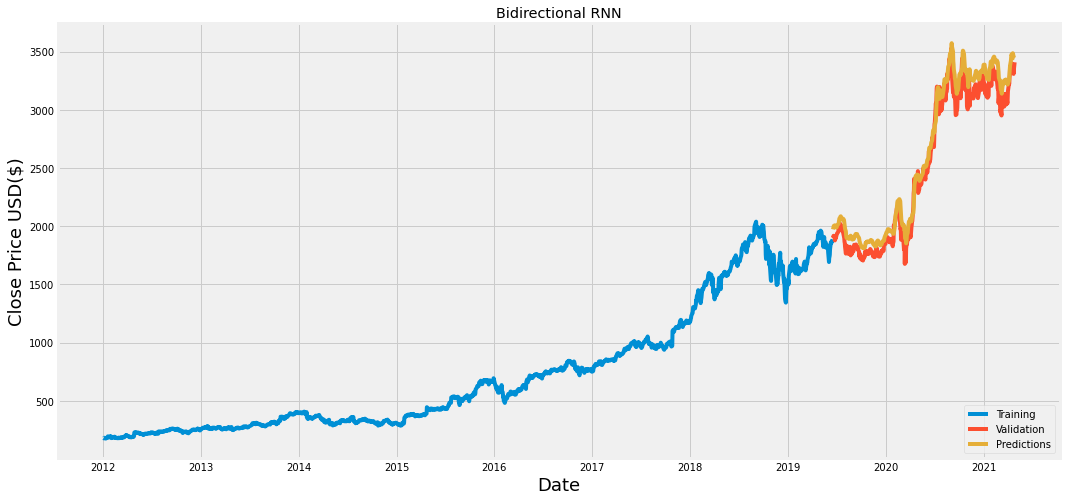

In [32]:
#Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Bidirectional RNN')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Training','Validation','Predictions'],loc='lower right')
plt.show()

In [33]:
valid

,Close,Predictions
Date,,
2019-06-18,1901.369995,1973.192139
2019-06-19,1908.790039,1984.021240
2019-06-20,1918.189941,1993.568359
2019-06-21,1911.300049,2002.967651
2019-06-24,1913.900024,2007.437866
...,...,...
2021-04-20,3334.689941,3484.123779
2021-04-21,3362.020020,3467.292236
2021-04-22,3309.040039,3462.381592
